In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Determinar grupos para reforço escolar

## Análise da Base de Dados

In [2]:
# data set extraido de https://www.kaggle.com/pertence/enem-enade#2016.csv

enem = pd.read_csv('2016.csv')

enem.head(5)

,nu_ano,co_ies,co_categ,co_orgacad,co_curso,co_grupo,co_munic,co_modalidade,tp_inscricao,nu_ano_inicio_graduacao,tp_pres,nt_ger,ano_enem,enem_nt_cn,enem_nt_ch,enem_nt_lc,enem_nt_mt
0,2016,1,10002,10028,7,38,5170340,1,0,2012,555,45.1,2011,494.8,558.3,570.7,490.1
1,2016,1,10002,10028,7,38,5170340,1,0,2012,a555,33.1,2011,560.3,529.4,571.7,612.7
2,2016,1,10002,10028,7,38,5170340,1,0,2012,555,72.4,2011,459.9,508.2,585.1,643.1
3,2016,1,10002,10028,7,38,5170340,1,0,2012,555,57.7,2011,487.0,460.1,558.7,629.5
4,2016,1,10002,10028,7,38,5170340,1,0,2012,555,60.8,2011,518.0,576.7,554.8,546.0


In [3]:
enem.columns

Index(['nu_ano', 'co_ies', 'co_categ', 'co_orgacad', 'co_curso', 'co_grupo',
       'co_munic', 'co_modalidade', 'tp_inscricao', 'nu_ano_inicio_graduacao',
       'tp_pres', 'nt_ger', 'ano_enem', 'enem_nt_cn', 'enem_nt_ch',
       'enem_nt_lc', 'enem_nt_mt'],
      dtype='object')

Para este estudo serão apenas avaliadas as notas por área de conhecimento.

Assim, abaixo o base será filtrada para utilizar apenas essas notas, sendo:

* enem_nt_cn - Nota em Ciências Naturais
* enem_nt_ch - Nota em Ciências Humanas
* enem_nt_lc - Nota em Literatura
* enem_nt_mt - Nota em Matemática

In [4]:
colunas = ['enem_nt_cn', 'enem_nt_ch','enem_nt_lc', 'enem_nt_mt']
enem = enem[colunas]

In [5]:
# Verifica algumas estatisticas da base
enem.describe()

,enem_nt_cn,enem_nt_ch,enem_nt_lc,enem_nt_mt
count,131129.000000,131129.000000,131129.000000,131129.000000
mean,517.422016,549.252486,543.740082,553.857042
std,96.193553,98.812884,76.635902,125.723594
min,267.900000,0.000000,224.300000,0.000000
25%,448.000000,483.600000,495.400000,456.600000
50%,509.900000,543.200000,546.100000,548.800000
75%,576.600000,605.700000,594.300000,637.900000
max,903.200000,883.700000,835.600000,973.200000


Nota-se notas zeradas para ciências humanas e matemática

In [6]:
enem.corr()

,enem_nt_cn,enem_nt_ch,enem_nt_lc,enem_nt_mt
enem_nt_cn,1.000000,0.785346,0.735563,0.749524
enem_nt_ch,0.785346,1.000000,0.737734,0.678501
enem_nt_lc,0.735563,0.737734,1.000000,0.667875
enem_nt_mt,0.749524,0.678501,0.667875,1.000000


Alta correlação em todas as variáveis, ou seja, quando maior a nota em uma área maior também em todas as outras

## Filtra a base e verifica consistência dos dados

Verifica se há valores nulos

In [7]:
enem.isnull().any()

enem_nt_cn    False
enem_nt_ch    False
enem_nt_lc    False
enem_nt_mt    False
dtype: bool

Verifica quais registros estão com valores zerados

In [8]:
enem[enem["enem_nt_ch"] == 0]

,enem_nt_cn,enem_nt_ch,enem_nt_lc,enem_nt_mt
81369,468.2,0.0,553.2,531.9


In [9]:
enem[enem["enem_nt_mt"] == 0]

,enem_nt_cn,enem_nt_ch,enem_nt_lc,enem_nt_mt
98897,558.7,567.5,501.3,0.0
127640,486.3,455.8,451.9,0.0


Considerando que as notas em outras áreas estão proximas da média, é estranho a nota estar zerada. Sendo assim, considerando que há mais de 131 mil registros na base, esses registros com nota zero serão excluídos

In [10]:
enem_sem_zero = enem[enem["enem_nt_ch"] != 0]
enem_sem_zero = enem_sem_zero[enem_sem_zero["enem_nt_mt"] != 0]

In [11]:
enem_sem_zero.describe()

,enem_nt_cn,enem_nt_ch,enem_nt_lc,enem_nt_mt
count,131126.000000,131126.000000,131126.000000,131126.000000
mean,517.422314,549.257249,543.741034,553.865657
std,96.194451,98.802022,76.636265,125.706408
min,267.900000,252.900000,224.300000,277.200000
25%,448.000000,483.600000,495.400000,456.600000
50%,509.900000,543.200000,546.100000,548.800000
75%,576.675000,605.700000,594.300000,637.900000
max,903.200000,883.700000,835.600000,973.200000


## Normaliza a base

In [12]:
# funcao para normalizar os dados pelo menor valor, ou seja, o valor menor valor será o zero
def normalize(df,colunas):
    df_aux = df.copy()
    for col in colunas:
        df_aux[col] = (df_aux[col] - df_aux[col].min()) / (df_aux[col].max() - df_aux[col].min())
    return (df_aux) 

In [13]:
enem_sem_zero = normalize(enem_sem_zero, colunas)
enem_sem_zero.describe()

,enem_nt_cn,enem_nt_ch,enem_nt_lc,enem_nt_mt
count,131126.000000,131126.000000,131126.000000,131126.000000
mean,0.392763,0.469812,0.522560,0.397508
std,0.151416,0.156630,0.125366,0.180613
min,0.000000,0.000000,0.000000,0.000000
25%,0.283488,0.365726,0.443481,0.257759
50%,0.380922,0.460209,0.526419,0.390230
75%,0.486030,0.559290,0.605267,0.518247
max,1.000000,1.000000,1.000000,1.000000


## Procura e remove outliers

In [14]:
def identificacao_outlier(df, col): 
    print(col)
 
    estat = df.describe()
    #Intervalo inter-quartil
    iq = (estat[col]["75%"] - estat[col]["25%"])
    #Limite superior para outlier é 5 vezes o intervalo interquartílica acima do 75% percentil
    lim_sup = estat[col]["75%"] + 5 * iq 
    #Limite inferior para outlier é 5 vezes o intervalo interquarílica abaixo do 25% percentil
    lim_inf = estat[col]["25%"] - 5 * iq 
    #Seleciona os elementos que seguem a regra calculada acima
    vet_out_sup = df[(df[col] > lim_sup)][[col]]
    vet_out_inf = df[(df[col] < lim_inf)][[col]]
    #Se algum elemento foi selecionado, imprima
    if (len(vet_out_sup) > 0 ):
       print("Quantidade de candidatos a outliers superiores para [" + col + "]: " + str(len(vet_out_sup))) 
       print("Limite: " + str(lim_sup))
    
    if (len(vet_out_inf) > 0 ):
       print("Quantidade de candidatos a outliers inferiores para [" + col + "]: " + str(len(vet_out_inf)))
       print("Limite: " + str(lim_inf))

In [15]:
for col in colunas: 
    identificacao_outlier(enem_sem_zero,col)

enem_nt_cn
enem_nt_ch
enem_nt_lc
enem_nt_mt


Não há mais outliers na base

## Usando método elbow para achar o k ideal

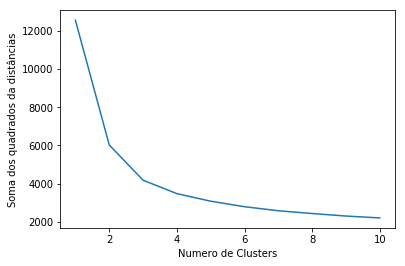

In [19]:
from sklearn.cluster import KMeans

np.random.seed(42)

square_sum = []
 
# Verifica com 10 clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, n_init=20)
    kmeans.fit(enem_sem_zero.values)
    square_sum.append(kmeans.inertia_)

# plota para termos uma melhor ideia do k
plt.plot(range(1, 11), square_sum)
plt.xlabel('Numero de Clusters')
plt.ylabel('Soma dos quadrados da distâncias') #within cluster sum of squares
plt.show()

Observando o gráfico acima, percebe-se que o k ideal, quando não há mais ganho, são 4 clusters

## Gerando o k-means novamente

In [20]:
enem_kmeans = KMeans(n_clusters=4, n_init=20)
enem_kmeans.fit(enem_sem_zero.values)
pd.Series(enem_kmeans.labels_).value_counts()

1    45522
2    36930
3    32737
0    15937
dtype: int64

## Observando os resultados

In [62]:
# 0 - enem_nt_cn
# 1 - enem_nt_ch
# 2 - enem_nt_lc
# 3 - enem_nt_mt

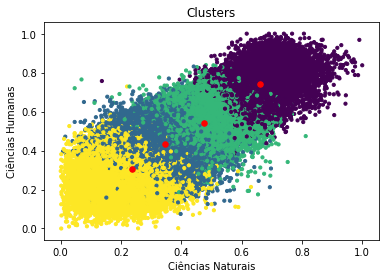

In [21]:
plt.scatter(enem_sem_zero.values[:,0], enem_sem_zero.values[:,1], s = 10,c = enem_kmeans.labels_)
plt.scatter(enem_kmeans.cluster_centers_[:, 0], enem_kmeans.cluster_centers_[:,1], s = 30, c = 'red',label = 'Centroids')
plt.title('Clusters')
plt.xlabel('Ciências Naturais')
plt.ylabel('Ciências Humanas')

plt.show()

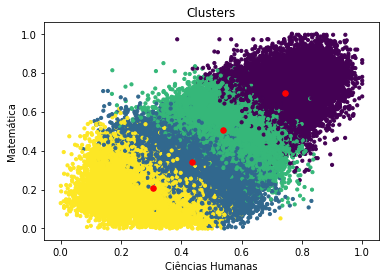

In [22]:
plt.scatter(enem_sem_zero.values[:,1], enem_sem_zero.values[:,3], s = 10,c = enem_kmeans.labels_)
plt.scatter(enem_kmeans.cluster_centers_[:, 1], enem_kmeans.cluster_centers_[:,3], s = 30, c = 'red',label = 'Centroids')
plt.title('Clusters')
plt.xlabel('Ciências Humanas')
plt.ylabel('Matemática')

plt.show()

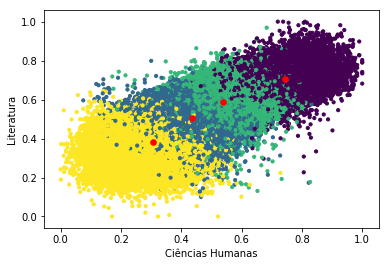

In [23]:
plt.scatter(enem_sem_zero.values[:,1], enem_sem_zero.values[:,2], s = 10,c = enem_kmeans.labels_)
plt.scatter(enem_kmeans.cluster_centers_[:, 1], enem_kmeans.cluster_centers_[:,2], s = 30, c = 'red',label = 'Centroids')
plt.xlabel('Ciências Humanas')
plt.ylabel('Literatura')

plt.show()

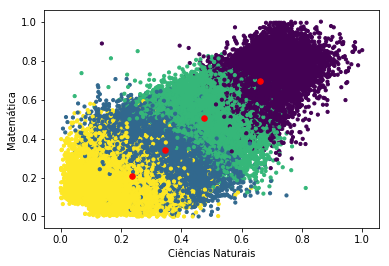

In [24]:
plt.scatter(enem_sem_zero.values[:,0], enem_sem_zero.values[:,3], s = 10,c = enem_kmeans.labels_)
plt.scatter(enem_kmeans.cluster_centers_[:, 0], enem_kmeans.cluster_centers_[:,3], s = 30, c = 'red',label = 'Centroids')
plt.xlabel('Ciências Naturais')
plt.ylabel('Matemática')

plt.show()

## Modelo Hierarquico

In [16]:
from scipy.cluster import hierarchy
# 0 - enem_nt_cn
# 1 - enem_nt_ch
# 2 - enem_nt_lc
# 3 - enem_nt_mt

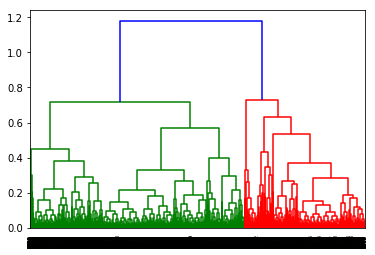

In [17]:
enem_ch_lt = enem_sem_zero[["enem_nt_ch", "enem_nt_lc"]]
Z = hierarchy.linkage(enem_ch_lt.head(10000), method = 'complete')
dendro = hierarchy.dendrogram(Z)
plt.show()

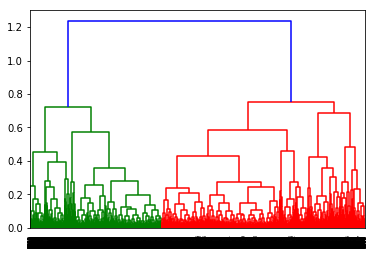

In [18]:
enem_cn_mt = enem_sem_zero[["enem_nt_cn", "enem_nt_mt"]]
Z = hierarchy.linkage(enem_cn_mt.head(10000), method = 'complete')
dendro = hierarchy.dendrogram(Z)
plt.show()